**ABSTRACT**                                                                                          |

| Title   | Maximizing the energy arbitrage revenue of a PV-BESS system under day-ahead electricity prices using linear programming |
|:-------|:-------------------------------------------------------------------------------------------------------------|
| Author | Tram Tran                                                                                                   |
| Year   | 2025                                                                                                        |
| Supervisor | Mikko Pieskä                                                                                             |


*This project uses linear programming (LP) to optimize the energy dispatch of a grid-connected PV-BESS system. Assuming real day-ahead (DA) electricity prices in Finland are known in advance, a simulation model is developed to determine the optimal hourly power allocation between selling electricity to the grid, charging/discharging the battery, or curtailing PV output. The objective is to maximize energy arbitrage revenue under realistic operational constraints. This is implemented in Python using the PuLP library with the CBC solver.*

# 1 INTRODUCTION

**<u>Context:</u>** Energy arbitrage—the strategy of buying electricity when prices are low and selling when prices are high—is becoming a popular operational approach in distributed energy systems. To leverage this potential, grid-connected systems combining PV solar panels and BESS are being widely deployed. However, a practical question arises: how can operators determine when to sell electricity to the grid, when to store energy, and when to curtail generation in order to maximize arbitrage revenue?

**<u>Goal:</u>** This project develops a LP (Linear Programing) model to simulate the operation of a grid-connected PV-BESS system under realistic conditions in Finland, using hourly DA electricity price data and solar irradiance. The objective is to determine the hourly power dispatch strategy (battery discharge, charging, curtailment, selling) that maximizes arbitrage revenue while respecting the system’s technical constraints.

**<u>Key questions:</u>**
- Based on a fixed limits PV-BESS-GRID system and DA price data, when should electricity be sold, stored, or curtailed to achieve maximum profit?
- How do battery degradation costs (cycle cost) and grid fees affect the operational strategy?
- How do changes in system configuration impact overall revenue?

# 2	BASIC IDEA OF THE PROJECT
This project investigates how **a grid-connected energy system — comprising a PV solar array and a BESS** — can be operated optimally in response to DA electricity prices, with the goal of maximizing revenue from energy arbitrage.
The basic configuration assumes:
- A fixed grid connection capacity (e.g., 10 MW),
- A PV system with higher peak output (e.g., 20 MW), and
- A BESS of defined power and energy capacity (e.g., 30 MWh).

Under this configuration, on sunny days when PV generation exceeds grid export limits, operators are faced with multiple options:
- Sell the maximum allowed power (10 MW) to the grid while storing excess energy in the BESS,
- Store more energy in the BESS for future sale during peak-price hours,
- Or curtail excess PV output if neither selling nor storing is viable or profitable.

The optimization model assumes perfect foresight of DA electricity prices over a 24-hour period and uses those prices as fixed inputs. The key operational logic is:
- When prices are high, prioritize discharging the battery and selling as much PV-generated electricity as technically allowed.
- When prices are low, prioritize charging the battery from PV or even from the grid (if cost-effective), and avoid selling to the grid.

While DA prices are treated as known and fixed, the technical parameters of the system — PV capacity, BESS size, and grid connection capacity — are treated as variables. This opens the door to sensitivity analysis to evaluate which system behavior delivers the highest revenue potential under different market scenarios.

# 3 PROBLEM APPROACH
## 3.1	Expand the traditional arbitrage model
The book [Monetizing Energy Storage (Schmidt & Staffell, 2023)](https://academic.oup.com/book/55104), especially ***Chapter 6*** helps me know the concept of arbitrage. However, the model presented in the book considers only a *grid-connected battery storage system*, where the two main decision variables are battery charging and discharging power. The energy flows are simplified into a two-way direction: **grid <-> battery**. 
In this study, I expand the traditional arbitrage model by integrating a solar PV system, hence the system is now PV-BESS-GRID which introduces additional energy flows and decision variables. The energy dispatch strategy of each hour of a combined system PV-BESS-GRID is:

The PV system can:
- Charge the battery
- Export electricity directly to the grid
- Or be curtailed if production exceeds technical limits

The battery can:
- Be charged from the PV system
- Be charged from the grid
- Discharge to sell electricity to the grid

The grid can:
- Provide electricity to charge the battery (import)
- Receive electricity from PV generation (export)
- Receive electricity from the battery (export)

With the system diagram drawn, the possible energy flow directions can be simplified into five paths, as illustrated in the diagram below: 

<img src="attachment:765cc4c2-8c8a-4cb6-a875-079caef0f50c.png" alt="image.png" width="350"/>

*Figure 1. Power flow analysis*

So now, the key responsibility is to determine which of the five above options to choose to maximize total revenue.  This decision needs to be made for each hour over a 24-hour period based on known DA electricity prices.

## 3.2	System constraints, and cost considerations
Given the increased system complexity, the model must incorporate a broader set of technical constraints, including:
- Maximum rated power of the PV system
- Maximum grid import/export capacity
- Charging/discharging power limits and energy capacity of the battery
- Battery round-trip efficiency
- State-of-charge (SoC) constraints
- ...

Additionally, revenue calculation from arbitrage becomes more com-plex compared to the original battery-grid model:
- Revenue: includes income from selling PV electricity and dis-charged battery energy to the grid, minus the cost of charging the battery from the grid
- Costs: may include electricity purchase costs, grid transmis-sion fees, energy taxes, VAT, and potential battery degrada-tion costs (cycle cost)

## 3.3	Testing multiple battery storage capacities 
Another point is that besides variations in DA prices, I want to examine the impact of system configuration on arbitrage revenue. There are many parameters that could affect this, such as maximum PV power, maximum grid power, maximum charge/discharge power, PV system efficiency, battery round-trip efficiency, and so on. However, I ultimately chose to focus on evaluating battery max capacity because:

*(1) Battery capacity directly affects the amount of energy that can be stored, significantly influencing the charging/discharging behavior (enabling participation in more or fewer arbitrage cycles, or even “long-duration arbitrage”), which in turn impacts the profit from buying and selling electricity.*

*(2) Since batteries represent a large share of the CAPEX in storage systems, finding the optimal capacity (not too large to cause waste, not too small to lose revenue) is a crucial question for investors.*

*(3) Currently, many battery systems are designed in modular form, so adding or removing modules is a straightforward and flexible way to adjust capacity. This is much simpler and more practical than changing fixed configurations such as grid power capacity or PV system size.*

In the final part of the model, I will perform a sensitivity analysis by testing multiple battery storage capacities, while keeping the PV system size and grid connection limits constant. The goal is to identify the battery capacity that yields the highest operational revenue under the given system configuration.

<u>Note:</u> This model is designed solely to optimize operational revenue within a 24-hour period, using DA electricity price forecasts. It does NOT account for capital investment, O&M costs, or long-term finan-cial analysis — the focus is strictly on short-term arbitrage revenue optimization.

# 4	METHODS AND TOOLS

## 4.1	LP model
The core objective of this problem is **to optimize energy system operation for maximum profit**. Common approaches include:

-	Monte Carlo: test random charge/discharge schedules and select the best.
-	Game theory: optimize trading strategy in markets with limited competition.
-	Calibrated moving averages: smooth renewable output or demand.
-	Functional algorithms: apply predefined charging/discharging rules.
-	Price pairing: match high prices for discharge and low prices for charge.
-	Reinforcement learning: learn strategies from historical price data.

(Schmidt et al, 2023)

However, in this case, DA prices are known 24 hours in advance (deterministic), making LP or MILP (Mixed-Integer Linear Programming) the most suitable. When both the objective function and constraints are linear, LP offers a fast and precise solution without requiring complex solvers.

The main remaining task is to define the variables and formulate a linear objective function along with constraints that closely reflect requirements and real operation. The LP model then determines the optimal solution.

## 4.2	Python
Overall process of how I solve the problem in this project, which contains 5 main steps:

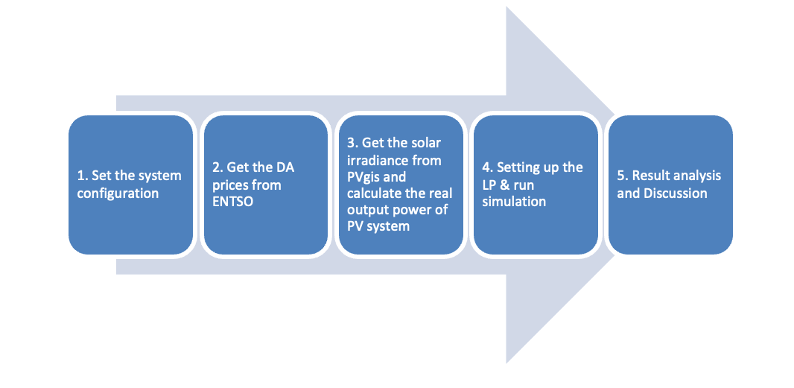

*Figure 2. Overall problem solving process*

Initially, I planned to use Excel because step (1), (2) and (3) can be easily done by the .csv file downloaded from the provider's website. Excel also has Solver — which can be configured to solve LP problems using its Simplex engine. However, due to the very large number of variables in this problem, Solver returned an error and was unable to find a solution.
 
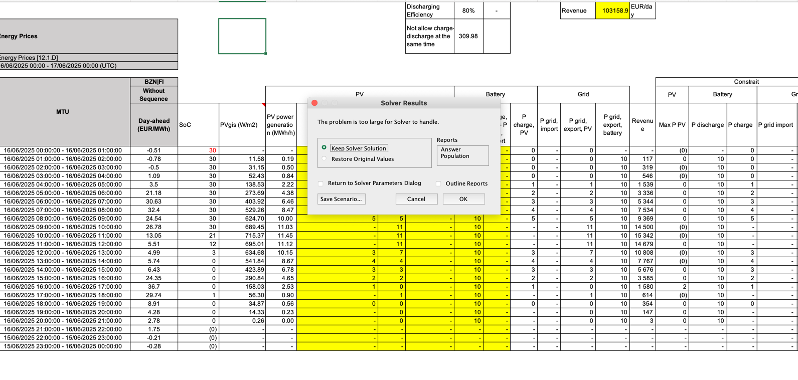

*Figure 3. Solver Excel limitation*

Therefore, the simulation will be implemented in Python, specifically:

- Data collection from PVGIS (solar radiation) and ENTSO-E (electricity prices) through calling their open APIs
- Energy dispatch optimization using PuLP — a Python library for LP that solves optimization problems using solvers like CBC (Coin-or branch and cut), an open-source solver efficient for energy scheduling and cost minimization (Keen, 2016). 
- Export results to Excel and visualization via Matplotlib

Running the model in Python can be challenging for those who are not familiar with programming when it comes to understanding the code syntax. However, in Section **5. DETAILED ALGORITHM DEPLOYMENT**, I have provided clear explanations of the meaning behind each segment of the code. Finally, the simulation results will be exported to an Excel file along with visual charts, making it easier for users to follow and understand.

# 5	DETAIL AGORITHM DEPLOYMENT

## 5.1	Load Python packages

Import the necessary packages (library) in Python for the project.

In [ ]:
import requests # fetch data from the Internet
from datetime import datetime, timedelta, time # handle date, time
import pytz # handle time zones
import pandas as pd # process data tables and perform data analysis
from entsoe import EntsoePandasClient #access electricity data
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus #solve linear programming optimization problems
import matplotlib.pyplot as plt #plot charts and graphs
import numpy as np #perform numerical operations and efficiently handle arrays

## 5.2	Assign the system parameters

The problem assumes that the hardware configuration parameters of the system is fixed, such as grid capacity, PV system capacity, battery capacity, etc. All these parameters are then defined as variables in Python for subsequent calculations. If you want to choose different system parameters or the location of the PV solar installation, or run the model using electricity prices from another country,... you can freely adjust these settings later.

### 5.2.1	PV solar system
-	Location: Vaasa, Finland
-	Slope = 70 degree, Azimuth = 0 degree
-	Maximum power capacity: assumed 20MW
-	System efficiency: assumed 80%

In [ ]:
## ----- STEP 1: SYSTEM CONFIGURATION 
## 1. PV SOLAR
lat = 63.096 #Finland
lon = 21.616
year = 2023  # Use 2023 data, because PVgis only provide historical data of solar irradiance from 2023 backwards.
PV_rated = 20  # MW, Max power of PV system
PR = 0.8 # System efficiency


### 5.2.2	BESS
-	Maximum battery capacity: assumed 20MWh
-	Maximum charging power: assumed 10MW
-	Maximum discharging power: assumed 10MW
-	Charging efficiency: assumed 90%
-	Discharging efficiency: assumed 90%
-	Initial battery capacity: assumed = 0%
-	Cycle cost: assumed 0€/MWh

In [ ]:
## 2. BESS
battery_capacity = 30  # MWh
charge_power_limit = 10  # MW
discharge_power_limit = 10  # MW
charge_eff = 0.9
discharge_eff = 0.9
initial_soc = 0.0 * battery_capacity
cycle_cost= 0 # €/MWh

### 5.2.3	Grid
-	Maximum grid connection capacity: assumed 20MW

In [ ]:
## 3. GRID
grid_power_limit = 10  # MW

## 5.3	Get DA price from ENTSO
Finland's electricity market operates under a DA pricing mechanism, in which the electricity prices for the following 24 hours are published daily between 13:45–14:45 local time in Finland (during daylight saving time).

ENTSO is a platform that provides electricity price information for all of Europe. Through their open API, we can obtain the DA electricity prices for Finland. You need to obtain your own API token by following the instructions provided on the ENTSO-E website.

However, I faced a small challenge with the time zone:
- The ENTSO API only accepts and returns values in UTC time
- Solar energy data is taken from PVGIS, which only accepts and returns values in local time
- Our optimization problem is more meaningful if we use local time

Therefore, we need to take additional steps:
- Convert the desired date and time from local time to UTC when calling the ENTSO API
- Then convert the retrieved price data back to local time

In [ ]:
## ----- STEP 2: GET THE D-A ELECTRICITY PRICE FROM ENTSO

# --- LOCAL TIMEZONE ---
T = 24 # Time range = 24 hours
helsinki_tz = pytz.timezone("Europe/Helsinki")
today = datetime.now(helsinki_tz).date()

# Get the desired date as local time
selected_date = today + timedelta(days=0) # User can set any date here
local_start = pd.Timestamp(datetime(selected_date.year, selected_date.month, selected_date.day), tz=helsinki_tz) # Choose Helsinki timezone
local_end   = local_start + pd.Timedelta(hours=24) #It makes 00:00 as default start time, we add 24 hours to cover full day

# Convert to UTC for ENTSO-E API
start_utc = local_start.tz_convert("UTC")
end_utc   = local_end.tz_convert("UTC")

# Query day-ahead prices between start_date and end_date (local time aware)
api_key = "replace your own key here" 
client = EntsoePandasClient(api_key=api_key)
country_code = '10YFI-1--------U'  # Finland's country code
prices = client.query_day_ahead_prices(country_code, start=start_utc, end=end_utc)

# Convert back to local for filtering
prices_local = prices.tz_convert(helsinki_tz)
prices_local = prices_local[(prices_local.index >= local_start) & (prices_local.index < local_end)]

# Round and list
da_prices = [round(price, 2) for price in prices_local]

print(f"✅ Got {len(da_prices)} prices for {selected_date.strftime('%Y-%m-%d')} local time")
print(da_prices)


As a result, we got a list of 24 values equivalent to DA price in 24 hours of the target date, from 00:00 to 23:00, saving in `da_prices` variable. If we want, we can adjust the parameter at timedelta(days=<mark>1</mark>) in the `selected_date` variable to get the data for another day.

## 5.4	Get the daily solar irradiance data from PVgis
To calculate the actual power output of the PV solar system, we need solar irradiance data G(i) at the location where the PV system is installed. In this project, it is assumed to be in Vaasa, Finland, with **slope = 70 degrees** and **azimuth = 0 degrees**. The solar irradiance data is collected hourly on a daily basis, as we need to calculate the PV solar output on an hourly scale. 

In [ ]:
## ----- STEP 3: GET THE HOURLY SOLAR IRRADIANCE FROM PVGIS & CALCULATE THE PV GENERATED POWER

# --- Call PVgis API to get hourly solar irradiance data ---
def get_pvgis_hourly(lat, lon, year):
    url = "https://re.jrc.ec.europa.eu/api/v5_3/seriescalc"
    params = {
        "lat": lat,
        "lon": lon,
        "startyear": year,
        "endyear": year,
        "usehorizon": 0,
        "outputformat": "json",
        "pvtechchoice": "crystSi",
        "mounting_system": "fixed",
        "angle": 70,  # slope
        "aspect": 0,  # azimuth
        "optimalinclination": 0
    }
    response = requests.get(url, params=params)
    data = response.json()
    if "outputs" not in data or "hourly" not in data["outputs"]:
        raise ValueError("API didn't return hourly data")
    return data["outputs"]["hourly"]

pvgis_data = get_pvgis_hourly(lat, lon, 2023)

However, PVGIS does not yet support hourly real-time data, and only provides historical data up to the year 2023. Moreover, the PVGIS API returns the full set of *8760 hourly values* for the entire year in one request with the time format for example, `20230115:0511` (The Joint Research Centre). The best option I can think of in this case is to use the data from 2023 with the corresponding dates from 2025.

Therefore, additional data processing is required:
-	Use historical data from 2023, but extract the day and month of the queried date
-	Filter the output of solar irradiance data to only the queried date, from 0:00 to 23:00
-	Convert the time format returned by the PVgis API from `"YYYYMMDD:HHMM"` to `"YYYYMMDDHH"`

In [ ]:
# --- Get datetime from PVGIS data response ---
def parse_pvgis_time(h):
    raw = h["time"]  # e.g. "20230731:2211"
    date_part, hm_part = raw.split(':')
    dt = datetime.strptime(date_part + hm_part[:2], "%Y%m%d%H")
    return dt

# --- Filter to correct the selected date and month ---
filtered_data = [
    h for h in pvgis_data
    if parse_pvgis_time(h).month == selected_date.month
    and parse_pvgis_time(h).day == selected_date.day
]

print(f"✅ Got {len(filtered_data)} solar irradiance records for {selected_date.strftime('%Y-%m-%d')} (local time)")

As a result, we obtain 24 values of solar irradiance G(i) in W/m², each corresponding to the same hourly time frame as the electricity price data.

## 5.5	Calculate the actual PV generated power

Formula for calculating PV power output at time *t* (Pantić et al., 2016):

$$
P_{actual}(t) = P_{rated} \times \frac{G_i(t)}{G_{STC}} \times PR
$$

where:
- $P_{actual}(t)$ : power output at time *t*  
- $P_{rated}$ : PV system rated power  
- $G_i(t)$ : solar irradiance at time *t*  
- $G_{STC}$ : standard irradiance under test conditions (usually 1000 W/m²)  
- $PR$ : performance ratio regarding overall system efficiency  

For example, if the PV rated power is 20 MW, the solar radiation $G_i(t)$ is 800 W/m², and the system efficiency is 80%, the power output will be:

$$
20 \, MW_p \times \frac{800 \, W/m^2}{1000 \, W/m^2} \times 80\% = 12.8 \, MW
$$

We applied this logic to Python as follows:

In [ ]:
# --- Calculate PV generated power ---
solar_irradiance = [h.get("G(i)", 0) for h in filtered_data]
pv_profile = [(G / 1000) * PV_rated * PR for G in solar_irradiance]

As a result we get a list of 24 hours of output power of PV solar sys-tem stored in `pv_profile` list.

## 5.6	Setting up the LP problem in PuLP
### 5.6.1	Initialize LP model
After getting the DA price and PV power hourly, we initialize the LP problem in Python. The problem is to maximize revenue/profit, so we use `LpMaximize`.

In [ ]:
## ----- STEP 4.1: START PULP OPTIMIZING MODEL
from pulp import *

In [ ]:
# --- Initialize model ---
prob = LpProblem("Energy_Optimization", LpMaximize)

### 5.6.2	Variables
As explained in the **3 PROBLEM APPROACH** section, the role of the current LP problem is to make decisions for the 5 power flow directions at each hour. Hence, we set up a for loop that runs over a 24-hour span, representing these five directions as variables in the LP—each subject to the shared constraint of being non-negative:

-	Charging the battery from PV: `pv2batt`
-	Selling electricity directly from PV to the grid: `pv2grid`
-	Curtailing PV power: `curtail`
-	Buying electricity from the grid to charge the battery: `grid2batt`
-	Discharging electricity from the battery to sell to the grid: `batt2grid`

We use the LpVariable name so PuLP will understand these are variables.

In [ ]:
# --- Decision variable ---
pv2batt = [LpVariable(f"pv2batt_{t}", lowBound=0) for t in range(T)]
pv2grid = [LpVariable(f"pv2grid_{t}", lowBound=0) for t in range(T)]
curtail = [LpVariable(f"curtail_{t}", lowBound=0) for t in range(T)]
grid2batt = [LpVariable(f"grid2batt_{t}", lowBound=0) for t in range(T)]
batt2grid = [LpVariable(f"batt2grid_{t}", lowBound=0) for t in range(T)]

**State-of-charge (SoC)**
The battery has limited capacity, so we need to include its SoC as one of the constraints. Therefore, we must declare the `soc` variable explicitly—if we don’t declare it as a variable in the LP model, we can’t add constraints involving it within the model.

In [ ]:
soc = [LpVariable(f"soc_{t}", lowBound=0, upBound=battery_capacity) for t in range(T)]

Additionally, we add one more binary variable to prevent the battery from charging and discharging at the same time.

In [ ]:
# --- Binary variable to prevent simultaneous charging/discharging ---
mode = [LpVariable(f"mode_{t}", cat="Binary") for t in range(T)]  # 1 if discharging, 0 if charging

-	`mode` is the name of the variable. 
-	`cat`="Binary" means the variable can only take values 0 or 1. 
-	`mode` = [LpVariable(f"mode_{t}", cat="Binary") for t in range(T)] creates a binary variable named `mode` that can only be 0 or 1 for each time step t from 0 to T-1.

### 5.6.3	Objective
After setting up all the decision variables, we define the optimization problem that PuLP will solve for us.  Our goal is to maximize revenue/profit within the optimization time horizon. The profit can be described as below:

$$
Profit = \sum_{t=0}^{T-1} 
\Big[ E_t^{export} \cdot cost_{export,t} 
- E_t^{import} \cdot cost_{import,t} 
- E_t^{(batt \to grid)} \cdot c_{cyc} \Big]
$$

where:
- $E_t^{export}$ : total energy exported to the grid at time *t*, from PV or battery  
- $E_t^{import}$ : total energy imported from the grid at time *t* to charge the battery  
- $cost_{import,t}$ : total cost per MWh of importing electricity at time *t*  
- $cost_{export,t}$ : total cost per MWh of exporting electricity at time *t*  
- $c_{cyc}$ : battery cycle degradation cost  
- $E_t^{(batt \to grid)}$ : energy discharged from battery to grid  

To make the model more realistic, I took into account some costs related to buying and selling electricity to the grid, including taxes, fees...:
$$
cost_{import} = energy_{import} + tax_{import} + transmission_{import}
$$

   + $energy_{import} = DA \, prices + marginal_{import} + VAT$  
   + $tax_{import} = tax_{electricity} + VAT$  
   + $transmission_{import} = energy_{(transmission,import)} + VAT$  

$$
cost_{export} = DA \, prices - marginal_{export} - (transmission_{export} + VAT)
$$
Therefore, the formula for the profit objective function will be as follows in Python code:

In [ ]:
## --- Objective function: maximize arbitrage profit ---
profit = lpSum([
    (pv2grid[t] + batt2grid[t]) * (da_prices[t]-marginal_export) - grid2batt[t] * (da_prices[t]*(1+VAT_tax)+marginal_import+consumption_tax+transmission_cost) - batt2grid[t] * cycle_cost

    for t in range(T)
])
prob += profit

Here, the costs related to grid fee are fixed in advance as example, I turn them into `€/MWh` unit.

In [ ]:
## 4. GRID fee
transmission_cost= 41.5 #Transmission cost 4.15c/kWh. Only apply for import
marginal_export=2 #Marginal price of selling to grid (no applied VAT) 0.2c/kWh
marginal_import=6 #Marginal price of buying from grid (included VAT) 0.6c/kWh
consumption_tax=27.9 #Consumption tax (included VAT) 2.79c/kWh
VAT_tax=0.24 #VAT 24%

### 5.6.4	Constraints
Having defined the model and the objective, we now need to add the constraints. We put all the constraints inside a for loop because the battery operation and power flows need to be defined and limited for each time step throughout the optimization horizon.

**Energy balance of PV output:** At each time step, total PV genera-tion equals the sum of power sent to the battery, exported to the grid, and curtailed

In [ ]:
# --- Constraints ---
for t in range(T):
    # 1. Total PV generated power = charge to battery + sell to grid + cultail
    prob += pv2batt[t] + pv2grid[t] + curtail[t] == pv_profile[t]

**State of Charge is updated hourly, with an initial SoC value:**

$$
SoC_t =
\begin{cases} 
SoC_0, & t = 0 \\
SoC_{t-1} + \text{charging amount} \times \eta_{charge} - \frac{\text{discharging amount}}{\eta_{discharge}}, & t > 0
\end{cases}
$$

- At the initial time **t = 0**, the SoC is set to the initial SoC value `initial_soc`.  
- For subsequent times **t > 0**, the SoC is updated based on:  
  - the previous time’s SoC,  
  - plus the charging energy (from PV and the grid) multiplied by the charging efficiency $\eta_{charge}$,  
  - minus the energy discharged to the grid divided by the discharging efficiency $\eta_{discharge}$.  


In [ ]:
# 2. SoC is updated per hour, initial SOC is assumed
    if t == 0:
        prob += soc[t] == initial_soc
    else:
        prob += soc[t] == soc[t-1] + (pv2batt[t] + grid2batt[t]) * charge_eff - batt2grid[t] / discharge_eff

**Charging and discharging power limits:** Charging power at any hour cannot exceed a maximum charge rate, and discharging power is similarly limited.

In [ ]:
# 3. Charging limit
    prob += pv2batt[t] + grid2batt[t] <= charge_power_limit

# 4. Discharging limit
    prob += batt2grid[t] <= discharge_power_limit

**No simultaneous charging and discharging:** We use the above binary variable mode[t] to control the state of the battery at each time t to prevent the battery from charging and discharging at the same time. But it still allows the idle state — that is, neither charging nor discharging.

In [ ]:
# 5. Do not charge + discharge at the same time (big-M method)
    prob += pv2batt[t] + grid2batt[t] <= charge_power_limit * (1 - mode[t])
    prob += batt2grid[t] <= discharge_power_limit * mode[t]

**Grid import and export limits:** The power imported from the grid to charge the battery and power exported to the grid (from PV or battery) have respective upper bounds.

In [ ]:
# 6. Limit power import from grid (charging only)
    prob += grid2batt[t] <= grid_power_limit

# 7. Limit the power exported to the grid (PV + batt)
    prob += pv2grid[t] + batt2grid[t] <= grid_power_limit

**Discharge availability constraint:** The battery cannot discharge more energy than it currently stores (SoC adjusted by discharging efficiency).

In [ ]:
# 8. Discharge amount <= SOC.
    if t == 0:
        prob += batt2grid[t] <= initial_soc*discharge_eff
    else:
        prob += batt2grid[t] <= soc[t-1]*discharge_eff

**End-of-horizon SoC constraint:** The battery’s  SoC at the end of the optimization horizon is forced to return to the initial SoC. This is done for two main reasons:

*(1) To encourage the battery to discharge its stored energy and sell it to the grid during hours with typically higher prices, usually from after 5:00 PM to before 11:00 PM. And this is only effective if we set the initial SoC low, for example, between 0 and 10% of the battery capacity.*

*(2) This avoids having a different initial SoC each day. If the initial SoC changed daily, the model—which only runs on a 24-hour horizon—would no longer apply accurately. Forcing the battery’s SoC at the end of the horizon to match the initial SoC ensures consistency and reliability across daily runs.*

In [ ]:
# 9. At the end of the day, force the battery to discharge to initial SOC.
    prob += soc[T-1] == initial_soc

And finally, the line of code runs the optimization problem using the CBC solver. The parameter `msg=False` suppresses detailed solver output, making the run cleaner by not displaying verbose logs on the screen. 

In [ ]:
# --- Solve ---
prob.solve(pulp.PULP_CBC_CMD(msg=False))

### 5.6.5	Simulation with variety of battery capacities 
Battery capacity directly impacts the ability to store and manage energy, which in turn affects revenue from selling electricity to the grid or savings from purchasing electricity. The key question is: **Assuming grid power, PV solar capacity, and other system parameters remain unchanged, what battery capacity is optimal for investment?** 

And once again, my problem does not consider *investment costs, operational costs, or other financial factors* that would be needed to make a definitive decision. We just want to avoid buying a battery that’s too small and doesn’t fully capture the profit potential, or too large and ends up wasting capital and incurring unnecessary maintenance costs.

Using a similar approach as before, we set up another LP problem to test different maximum battery capacities, for example ranging *from 5 to 70 MWh.*

In [ ]:
## STEP 4.2: TRY VARIOUS BATTERY CAPACITIES FROM 5 → 50 MWh ---
results = []

for cap in range(5, 71, 5):  # from 5 to 70 MWh (5, 10, 15, 20...)

    # --- Create new model ---
    prob2 = LpProblem("Energy_Optimization", LpMaximize)

    # --- Variable declaration ---
    pv2batt2 = [LpVariable(f"pv2batt_{t}", lowBound=0) for t in range(T)]
    pv2grid2 = [LpVariable(f"pv2grid_{t}", lowBound=0) for t in range(T)]
    curtail2 = [LpVariable(f"curtail_{t}", lowBound=0) for t in range(T)]
    grid2batt2 = [LpVariable(f"grid2batt_{t}", lowBound=0) for t in range(T)]
    batt2grid2 = [LpVariable(f"batt2grid_{t}", lowBound=0) for t in range(T)]
    soc_optimize = [LpVariable(f"soc_optimize_{t}", lowBound=0, upBound=cap) for t in range(T)]
    mode = [LpVariable(f"mode_{t}", cat="Binary") for t in range(T)]

    # --- Constraints  ---
    for t in range(T):
        prob2 += pv2batt2[t] + pv2grid2[t] + curtail2[t] == pv_profile[t]

        if t == 0:
            prob2 += soc_optimize[t] == initial_soc
        else:
            prob2 += soc_optimize[t] == soc_optimize[t-1] + (pv2batt2[t] + grid2batt2[t]) * charge_eff - batt2grid2[t] / discharge_eff

        prob2 += pv2batt2[t] + grid2batt2[t] <= charge_power_limit
        prob2 += batt2grid2[t] <= discharge_power_limit
        prob2 += pv2batt2[t] + grid2batt2[t] <= charge_power_limit * (1 - mode[t])
        prob2 += batt2grid2[t] <= discharge_power_limit * mode[t]
        prob2 += grid2batt2[t] <= grid_power_limit
        prob2 += pv2grid2[t] + batt2grid2[t] <= grid_power_limit

        if t == 0:
            prob2 += batt2grid2[t] <= initial_soc * discharge_eff
        else:
            prob2 += batt2grid2[t] <= soc_optimize[t-1] * discharge_eff
        prob2 += soc_optimize[T-1] == initial_soc

    # --- Target function ---
    profit_optimize = lpSum([
        (pv2grid2[t] + batt2grid2[t]) * (da_prices[t]-marginal_export) -
        grid2batt2[t] * (da_prices[t]*(1+VAT_tax)+marginal_import+consumption_tax+transmission_cost) -
        batt2grid2[t] * cycle_cost
        for t in range(T)
    ])

    prob2 += profit_optimize
    prob2.solve(pulp.PULP_CBC_CMD(msg=False))


    # --- Save the result ---
    profit_optimize_val = value(prob2.objective)
    results.append({
        "Battery Capacity (MWh)": cap,
        "Profit (€)": round(profit_optimize_val, 2),
    })

Finally, we write commands to display the solver results on the screen, export them to an Excel file, and plot them on a graph for easier result analysis.

In [ ]:
# STEP 5: PRINT THE RESULT & VISUALIZATION ---

##Print the power flow result
print("\n--- Optimized result---")
for t in range(T):
    hour_label = datetime(selected_date.year, selected_date.month, selected_date.day, t).strftime('%Y-%m-%d %H:%M')
    print(
        f"{hour_label} | PV: {pv_profile[t]:.2f} MW | Price: {da_prices[t]:.2f} €/MWh | "
        f"PV→BATT: {pv2batt[t].varValue:.2f} | PV→GRID: {pv2grid[t].varValue:.2f} | CURT: {curtail[t].varValue:.2f} | "
        f"GRID→BATT: {grid2batt[t].varValue:.2f} | BATT→GRID: {batt2grid[t].varValue:.2f} | SoC: {soc[t].varValue:.2f}"
    )

print(f"Status: {LpStatus[prob.status]}")
print(f"Objective (Profit): {value(prob.objective):.2f} €")
profit_value = value(prob.objective)


# --- Find the optimal battery capacity ---
df_results = pd.DataFrame(results)
best_row = df_results.loc[df_results["Profit (€)"].idxmax()]
print("\n📈 Profit by battery capacity:")
print(df_results)

print("\n🏆 Best configuration:")
print(best_row)

## Create the Excel file


time_labels = [datetime(selected_date.year, selected_date.month, selected_date.day, t).strftime('%Y-%m-%d %H:%M') for t in range(T)]
time_labels_short = [t[-5:] for t in time_labels] 


pv2batt_val = [pv2batt[t].varValue for t in range(T)]
pv2grid_val = [pv2grid[t].varValue for t in range(T)]
curtail_val = [curtail[t].varValue for t in range(T)]
grid2batt_val = [grid2batt[t].varValue for t in range(T)]
batt2grid_val = [batt2grid[t].varValue for t in range(T)]
soc_val = [value(soc[t])/battery_capacity*100 for t in range(T)]

df_data = pd.DataFrame({
    'Time': time_labels,
    'Day-Ahead Price (€/MWh)': da_prices,
    'Solar Irradiance (W/m²)': solar_irradiance,
    'PV Power (MW)': pv_profile,
    'PV → Grid (MW)': pv2grid_val,
    'PV → Battery (MW)': pv2batt_val,
    'PV Curtailment (MW)': curtail_val,
    'Grid → Battery (MW)': grid2batt_val,
    'Battery → Grid (MW)': batt2grid_val,
    'Battery SoC (%)': soc_val
})

df_config = pd.DataFrame({
    'Parameter': [
        'Objective (Profit) (€)',
        'PV solar rated power (MW)',
        'Grid rated power (MW)',
        'Battery maximum capacity (MWh)',
        'Battery discharge rated power (MW)',
        'Battery charge rated power (MW)',
        'Charge/Discharge efficiency (%)'
    ],
    'Value': [
        round(profit_value, 2),
        PV_rated,
        grid_power_limit,
        battery_capacity,
        discharge_power_limit,
        charge_power_limit,
        discharge_eff
        
    ]
})

output_path = f"REPLACE YOUR DRIVE PATH HERE/energy_arbitrage_{selected_date.strftime('%Y-%m-%d')}.xlsx"
try:
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        df_config.to_excel(writer, sheet_name='Sheet1', index=False, startrow=0)
        start_row = len(df_config) + 3
        df_data.to_excel(writer, sheet_name='Sheet1', index=False, startrow=start_row)
        df_results.to_excel(writer, sheet_name='Sheet1', index=False, startrow=start_row + 27)

    print(f"✅ Excel file saved at:\n{output_path}")
except Exception as e:
    print(f"❌ Error when writing Excel file: {e}")

## Plot

fig = plt.figure(figsize=(12, 9))
fig.suptitle(f"Energy Arbitrage ({selected_date.strftime('%Y-%m-%d')})", fontsize=16)

# --- Subplot 1: PV profile + DA price ---
x = np.arange(len(time_labels))
ax1 = plt.subplot(4, 1, 1)

# Stacked bars
ax1.bar(x, pv2grid_val, label='PV → Grid', color='gold')
ax1.bar(x, pv2batt_val, bottom=pv2grid_val, label='PV → Battery', color='orange')
ax1.bar(x, curtail_val, bottom=np.array(pv2grid_val) + np.array(pv2batt_val),
        label='Curtailment', color='gray', alpha=0.7)

ax1.set_ylabel('Power (MW)')
ax1.set_title('PV Profile per Hour + DA Price')
ax1.set_xticks(x)
ax1.set_xticklabels(time_labels_short, rotation=45)
ax1.grid(True, axis='y')

# DA price (gray dashed)
ax1_price = ax1.twinx()
ax1_price.plot(x, da_prices, color='gray', linestyle='--', label='Day-Ahead Price (€/MWh)')
ax1_price.set_ylabel('€/MWh', color='gray')
ax1_price.tick_params(axis='y', labelcolor='gray')

# Legend
bars_labels = [ax1.patches[0], ax1.patches[len(x)], ax1.patches[2*len(x)]]
bar_names = ['PV → Grid', 'PV → Battery', 'Curtailment']
lines_labels = [ax1_price.lines[0]]
line_names = ['Day-Ahead Price (€/MWh)']
ax1.legend(bars_labels + lines_labels, bar_names + line_names, loc='upper left')

# --- Subplot 2: Battery SoC + DA price ---
ax2 = plt.subplot(4, 1, 2)
ax_soc = ax2
ax_price = ax2.twinx()

bar_width = 0.4
ax_soc.bar(x, [100]*len(soc_val), color='lightgray', width=bar_width, label='Max Capacity')
soc_bar = ax_soc.bar(x, soc_val, color='purple', width=bar_width, label='Battery SoC (%)')
ax_soc.set_ylabel('State of Charge (%)', color='purple')
ax_soc.set_ylim(0, 110)
ax_soc.tick_params(axis='y', labelcolor='purple')
ax_soc.set_title('Battery SoC and Day-Ahead Price')
ax_soc.set_xticks(x)
ax_soc.set_xticklabels(time_labels_short, rotation=45)
ax_soc.grid(True, axis='y')

price_line = ax_price.plot(x, da_prices, color='gray', linestyle='--', label='Day-Ahead Price (€/MWh)')
ax_price.set_ylabel('€/MWh', color='gray')
ax_price.tick_params(axis='y', labelcolor='gray')

ax_soc.legend([soc_bar[0], price_line[0]], ['Battery SoC (%)', 'Day-Ahead Price (€/MWh)'], loc='upper left')

# --- Subplot 3: Battery/Grid flows vs price ---
ax3 = plt.subplot(4, 1, 3)
ax_flow = ax3
ax_price2 = ax3.twinx()

flow_b2g = ax_flow.plot(x, batt2grid_val, color='blue', marker='s', label='Battery → Grid (MW)')
flow_g2b = ax_flow.plot(x, grid2batt_val, color='green', marker='^', label='Grid → Battery (MW)')
ax_flow.set_ylabel('Power (MW)')
ax_flow.set_xticks(x)
ax_flow.set_xticklabels(time_labels_short, rotation=45)
ax_flow.grid(True, axis='y')

price_line2 = ax_price2.plot(x, da_prices, color='gray', linestyle='--', label='Day-Ahead Price (€/MWh)')
ax_price2.set_ylabel('€/MWh', color='gray')

lines_labels3 = flow_b2g + flow_g2b + price_line2
labels3 = ['Battery → Grid (MW)', 'Grid → Battery (MW)', 'Day-Ahead Price (€/MWh)']
ax_flow.legend(lines_labels3, labels3, loc='upper left')
ax_flow.set_title('Battery/Grid Flows vs Day-Ahead Price')

# --- Subplot 4: Profit vs Battery Capacity ---
ax4 = plt.subplot(4, 1, 4)
ax4.plot(df_results["Battery Capacity (MWh)"], df_results["Profit (€)"], marker='o')
ax4.set_title("Profit vs Battery Capacity")
ax4.set_xlabel("Battery Capacity (MWh)")
ax4.set_ylabel("Profit (€)")
ax4.grid(True)
ax4.axvline(best_row["Battery Capacity (MWh)"], color='red', linestyle='--',
            label=f"Max Profit at {int(best_row['Battery Capacity (MWh)'])} MWh")
ax4.legend()

# --- Add system configuration (align with chart start) ---
system_info = (
    f"Profit (€): {profit_value:.2f}\n"
    f"PV solar rated power (MW): {PV_rated}\n"
    f"Grid rated power (MW): {grid_power_limit}\n"
    f"Battery maximum capacity (MWh): {battery_capacity}\n"
    f"Battery discharge rated power (MW): {discharge_power_limit}\n"
    f"Charge/Discharge efficiency: {discharge_eff}"
)
bbox = ax1.get_position()
plt.figtext(bbox.x0, 0.98, system_info, fontsize=7, ha='left', va='top')

# --- Layout adjustments ---
plt.tight_layout()                # Auto alignment
plt.subplots_adjust(top=0.9,     # Leave top space for suptitle
                    bottom=0.05)  # Leave bottom space for chart 4
plt.show()


# 6	RESULT ANALYSIS 
Below, we will analyze the results for August 10, 2025 to evaluate the model. We will go through the following three aspects:

- Accuracy of the data
- Compliance with the system’s technical constraints
- Reasonableness of the energy distribution strategy


| **Parameter**                        | **Value**   |
|--------------------------------------|-------------|
| Objective (Profit) (€)               | 1923.42     |
| PV solar rated power (MW)            | 20          |
| Grid rated power (MW)                | 10          |
| Battery maximum capacity (MWh)       | 30          |
| Battery discharge rated power (MW)   | 10          |
| Battery charge rated power (MW)      | 10          |
| Charge/Discharge efficiency (%)      | 0.9         |

*Table 1. The sample of system configuration for running simulation with the DA price on 2025-08-10*


| Time              | Day-Ahead Price (€/MWh) | Solar Irradiance (W/m²) | PV Power (MW) | PV → Grid (MW) | PV → Battery (MW) | PV Curtailment (MW) | Grid → Battery (MW) | Battery → Grid (MW) | Battery SoC (%) |
|-------------------|--------------------------|--------------------------|---------------|----------------|-------------------|---------------------|---------------------|---------------------|-----------------|
| 2025-08-10 00:00 | 2.79  | 0     | 0       | 0      | 0        | 0 | 0 | 0  | 0         |
| 2025-08-10 01:00 | 3.78  | 0     | 0       | 0      | 0        | 0 | 0 | 0  | 0         |
| 2025-08-10 02:00 | 3.57  | 0     | 0       | 0      | 0        | 0 | 0 | 0  | 0         |
| 2025-08-10 03:00 | 4.36  | 2.43  | 0.03888 | 0      | 0.03888  | 0 | 0 | 0  | 0.11664   |
| 2025-08-10 04:00 | 4.53  | 37.07 | 0.59312 | 0      | 0.59312  | 0 | 0 | 0  | 1.896     |
| 2025-08-10 05:00 | 3.50  | 126.95| 2.03120 | 0      | 2.03120  | 0 | 0 | 0  | 7.9896    |
| 2025-08-10 06:00 | 4.38  | 334.61| 5.35376 | 0      | 5.35376  | 0 | 0 | 0  | 24.05088  |
| 2025-08-10 07:00 | 5.12  | 546.24| 8.73984 | 8.5092 | 0.23061  | 0 | 0 | 0  | 24.74272  |
| 2025-08-10 08:00 | 6.80  | 706.90| 11.3104 | 10     | 1.3104   | 0 | 0 | 0  | 28.67392  |
| 2025-08-10 09:00 | 7.13  | 807.85| 12.9256 | 10     | 2.9256   | 0 | 0 | 0  | 37.45072  |
| 2025-08-10 10:00 | 2.77  | 286.14| 4.57824 | 0      | 4.57824  | 0 | 0 | 0  | 51.18544  |
| 2025-08-10 11:00 | 0.03  | 171.82| 2.74912 | 0      | 2.74912  | 0 | 0 | 0  | 59.4328   |
| 2025-08-10 12:00 | 0.00  | 235.03| 3.76048 | 0      | 3.76048  | 0 | 0 | 0  | 70.71424  |
| 2025-08-10 13:00 | 0.01  | 362.50| 5.80000 | 0      | 5.80000  | 0 | 0 | 0  | 88.11424  |
| 2025-08-10 14:00 | 0.02  | 107.38| 1.71808 | 0      | 1.71808  | 0 | 0 | 0  | 93.26848  |
| 2025-08-10 15:00 | 1.25  | 140.24| 2.24384 | 0      | 2.24384  | 0 | 0 | 0  | 100       |
| 2025-08-10 16:00 | 8.29  | 103.99| 1.66384 | 1.6638 | 0        | 0 | 0 | 0.5592 | 97.9288 |
| 2025-08-10 17:00 | 6.00  | 43.15 | 0.69040 | 0      | 0.69040  | 0 | 0 | 0  | 100       |
| 2025-08-10 18:00 | 30.03 | 3.04  | 0.04864 | 0.0486 | 0        | 0 | 0 | 0  | 100       |
| 2025-08-10 19:00 | 66.40 | 0     | 0       | 0      | 0        | 0 | 0 | 0  | 100       |
| 2025-08-10 20:00 | 68.61 | 0     | 0       | 0      | 0        | 0 | 0 | 10 | 62.963    |
| 2025-08-10 21:00 | 65.24 | 0     | 0       | 0      | 0        | 0 | 0 | 0  | 62.963    |
| 2025-08-10 22:00 | 67.46 | 0     | 0       | 0      | 0        | 0 | 0 | 7  | 37.037    |
| 2025-08-10 23:00 | 67.79 | 0     | 0       | 0      | 0        | 0 | 0 | 10 | 0         |

*Table 2. The simulation result for 2025-08-10*

## 6.1	Accuracy of the data
Electricity price data: retrieved exactly as expected when cross-checked against the .csv file downloaded via the user interface on the ENTSO website: https://newtransparency.entsoe.eu/market/energyPrices 

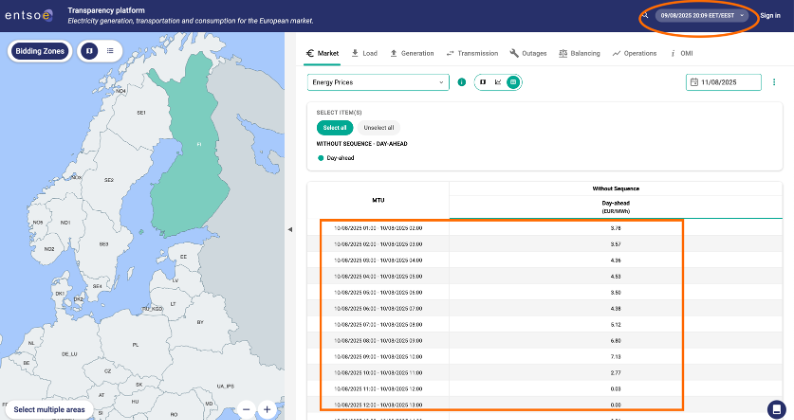

*Figure 4. DA price getting on ENTSO website*

**Solar PV data:** retrieved exactly as expected when cross-checked against the .csv file downloaded via the user interface on the PVGIS website: http://re.jrc.ec.europa.eu/pvg_tools/en/#MR. 
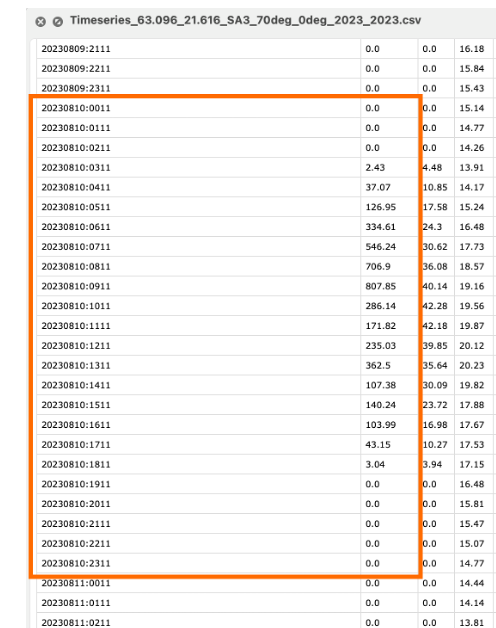

*Figure 5. Solar irradiance PV in .csv file getting from the PVgis website*

Consequently, the calculated PV solar output power also matches accordingly. 
## 6.2	Compliance with the system’s technical constraints
- SoC does not exceed the maximum level (e.g., 30 MWh) and is never negative → **Yes**
- Battery charge/discharge power is always within the specified limits (e.g., 10 MW) → **Yes**
- Power injected to or drawn from the grid in any given hour does not exceed the grid capacity (e.g., 10 MW) → **Yes**
- The battery never charges and discharges simultaneously → **Yes**
- Discharged energy from the battery never exceeds the available SoC → **Yes**
- End-of-day SoC returns to the initial value → **Yes**

Therefore, from a technical constraint perspective, the results fully comply with the system’s requirements. 
 
## 6.3	Reasonableness of the energy distribution strategy
### 6.3.1	SoC vs Electricity price
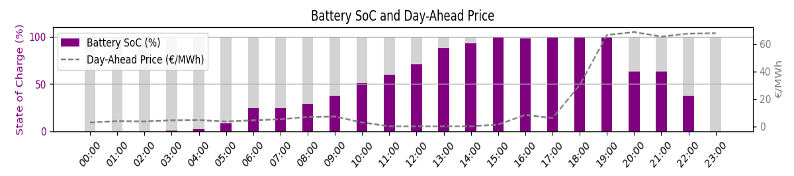

*Figure 6. SoC vs Electricity price 2025-08-10*

The chart shows that the SoC pattern is opposite to the electricity price trend: when the price is low, SoC is high, and vice versa. This aligns with the arbitrage strategy of charging the battery when prices are low and selling when prices are high.
During the peak price period from 19:00 to 23:00, the battery discharges electricity to the grid, causing SoC to decrease.
- At 20:00, the price is the highest of the day → the system sells up to the grid limit.
- At 21:00, the price remains high but is lower than the following hour → the system holds and does not sell.
- At 22:00, the price is still high but less than the next hour → it does not sell at maximum yet, saving capacity to sell at maximum in the following hour.
### 6.3.2	PV power behavior: charge battery, sell to grid, or cur-tailment
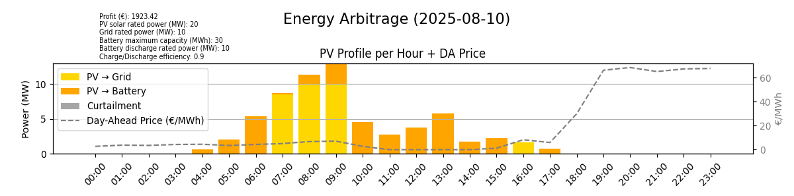

*Figure 7. PV system behavior vs Electricity price 2025-08-10*

We will analyze PV’s behavior throughout the day regarding the choices of charging the battery, selling to the grid, or curtailment to assess whether this behavior is reasonable.
- **03:00 – 06:00**, price 3.50 – 4.53 €/MWh (low) → PV→BATT: all PV energy is directed to the battery for storage, to be sold later during peak hours (evening).
- **07:00 – 09:00**, price 5.12 – 7.13 €/MWh (moderate to fairly high) → PV→GRID nearly 10 MW (grid limit reached). No curtailment since selling to the grid is profitable (price > grid cost). The surplus PV energy is stored in the battery if there is remaining capacity.
- **10:00 – 15:00**, price 0.00 – 2.77 €/MWh (very low) → 100% PV→BATT. No selling to the grid, because it would incur losses due to grid costs. The battery is fully charged by 15:00 (SoC = 30.00).
- **16:00 – 17:00**, price 6.00 – 8.29 €/MWh (quite high)
  *At 16:00: PV→GRID 1.66 MW → partly selling early because the battery is at full capacity. Simultaneously, the battery also discharges some power to the grid due to favorable prices compared to the following hours.*
  *At 17:00: PV→BATT 0.69 MW → recharging the battery a bit to bring SoC back to full before the peak price period starting after 18:00.*
- **18:00 – 23:00**, price 30.03 – 68.61 €/MWh (peak price) → PV power is nearly zero, but any PV generation (e.g., 0.05 MW at 18:00) is sold fully to the grid.
We can summarize the PV energy distribution strategy as follows:
- When prices are low: PV prioritizes 100% battery charging → no selling.
- When prices are moderate: PV splits tasks — sells as much as allowed by the grid limit and stores the surplus in the battery.
- When prices are high: PV sells directly to the grid without charging.
- Curtailment only happens when the battery is full or selling to the grid would cause losses.
So, the energy distribution logic aligns well with the goal of maximizing profit.
### 6.3.3	Impact of grid cost to the system behavior
When we adjust the grid cost value, for example setting it all to zero so that only the DA prices (SPOT) affect the system, the system’s behavior changes significantly.

In [ ]:
## 4. GRID fee
transmission_cost= 0 
marginal_export=0 
marginal_import=0 
consumption_tax=0 
VAT_tax=0

- The total arbitrage profit for the day increases from €1923.42 to €2107.27.
- At 12:00, PV generated 3.76 MW but the electricity price was zero. Therefore, all PV power was curtailed—none was used to charge the battery or sold to the grid. Instead, the system charged the battery with 10 MW drawn from the grid, achieving the same economic outcome as charging the battery with PV power.
- 
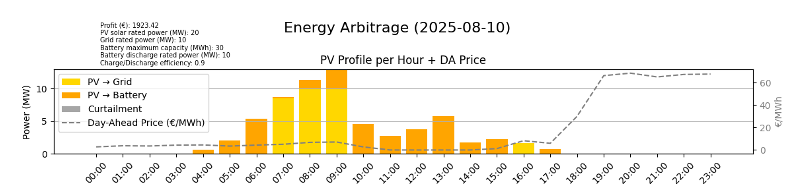

*Figure 8. PV system behavior under impact of grid cost 2025-08-10*


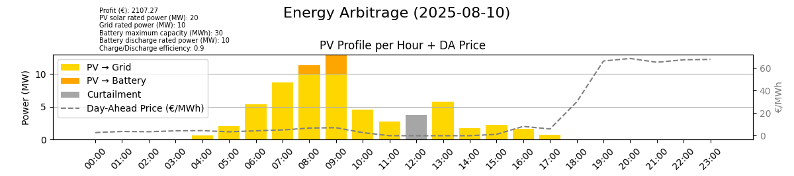

*Figure 9. PV system behavior without grid cost 2025-08-10*


- The battery charges and discharges to the grid multiple times throughout the day.
  
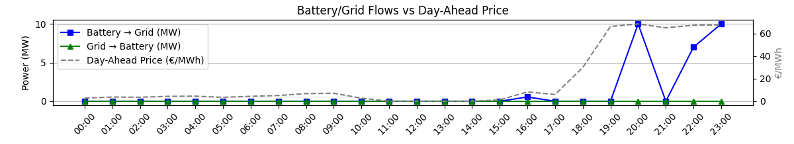

*Figure 10. Battery behavior under impact of grid cost 2025-08-10*


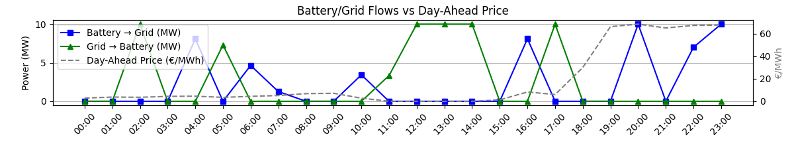

*Figure 11. Battery behavior without grid cost 2025-08-10*

### 6.3.4	Simulation with different sizes of battery to find the best configuration

With the following fixed assumptions:
- Grid power capacity: 10 MW
- Battery charge/discharge power: 10 MW
- Maximum PV solar power: 20 MW
- Grid costs and cycle costs are fully accounted for
- DA electricity prices for the date 2025-08-10

The model was tested with varying battery capacities ranging from 5 to 70 MWh. The corresponding maximum discharge time ranges approximately from 0.45 to 6.3 hours, calculated using the formula:

$$
t_{max \, discharge} = \frac{Battery_{max \, capacity} \times \eta_{discharge}}{Grid_{max \, power}}
$$

The results show that the smallest battery capacity yielding the highest profit is 55 MWh, corresponding to a maximum discharge time of about 4.95 hours. For capacities beyond this value, profit does not increase. Therefore, 55 MWh is identified as the optimal battery capacity to maximize profit.

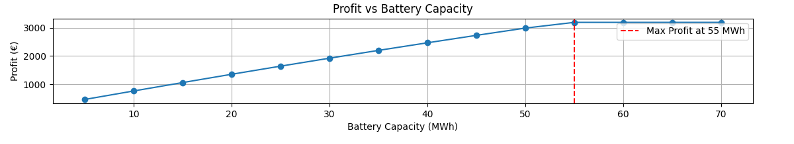

*Figure 12. Profit vs Battery max capacity 2025-08-10*

When we change one of the fixed assumptions above, the battery capacity that yields the maximum profit will also change. For example, in the figure below, I ran simulations to determine the optimal battery capacity that maximizes profit under different DA prices across various days.

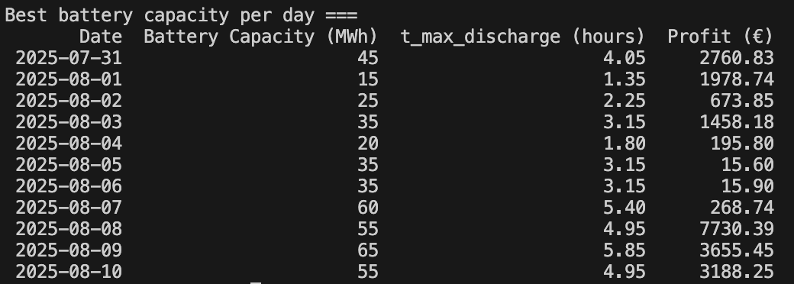

*Figure 13. Battery capacity that maximizes profit under different DA prices*

If we extend the simulation period, for example to one year, we can statistically analyze which range of max discharge time most often results in the highest profitability. This insight can help investors decide on the optimal battery capacity to choose—specifically, how large it should be relative to the grid power capacity. Many sources state that the optimal battery discharge duration for maximizing arbitrage profits is between 2 - 4 hours (Energy Storage News, 2020), and this running allows us to independently verify that result.

# DISCUSSION
## Benefits of the model
- The model incorporates PV solar generation, making it more complex than the conventional battery-grid arbitrage models, yet better aligned with current real-world trends.
- It uses real-time DA prices, improving the realism of the simulation.
- The use of LP ensures results that meet expectations, while also being simpler compared to other mathematical optimization approaches such as mixed-integer nonlinear programming (MINLP) or stochastic optimization.

## Limitations of the model
- The energy arbitrage problem is only suitable for solving with LP when the objective function and all constraints can be expressed linearly in the decision variables. If there are nonlinear elements, other methods or approximations are required. Real-world examples that make the model nonlinear include:
- Battery charge/discharge efficiency depending on the state of charge.
- Battery degradation as a function of the number of cycles or load, leading to cycle cost being a nonlinear function of discharge rate or cycle energy.
- Electricity selling prices that are not in a fixed day-ahead (DA) format but update in real time or are uncertain.
- There are many fixed parameters and assumptions, such as system configuration, grid costs and cycle cost. Instead of assigning fixed values, it would be preferable to allow parameters to vary within certain ranges. However, implementing this would require more advanced algorithms and greater computational resources, which are beyond the scope of the current project.
- Solar irradiance data is based on historical records rather than real-time measurements, which may reduce accuracy. Obtaining real-time solar irradiance data would require access to paid services or specialized APIs.
- The solar irradiance data is based on the year 2023, which is not a leap year. If you run this model in a year that includes February 29, when calling the PVGIS API, you will need to use a different year—such as 2020—or, if you’re lucky, they may have already provided data for 2024.
 
## Future work and potential extensions
Possible future extensions of this model:
- Incorporate more complex system configurations, such as variable PV sizes, varying efficiencies, and dynamic system components.
- Include load demand profiles to better represent real energy consumption patterns.
- Extend the model beyond Li-ion batteries to other storage technologies like fuel cells, where profitability would also depend on hydrogen sales revenue.
- Integrate economic performance indicators such as Levelized Cost of Energy (LCOE), Weighted Average Cost of Capital (WACC), Internal Rate of Return (IRR), and Net Present Value (NPV), as well as CAPEX/OPEX considerations for comprehensive investment analysis
 
# REFERENCES
- Schmidt, O., & Staffell, I. (2023). Chapter 6 (pp. 189–218). In Mone-tizing Energy Storage: A Toolkit to Assess Future Cost and Val-ue. Oxford University Press. https://doi.org/10.1093/oso/9780192888174.001.0001
- Schmidt, O., & Staffell, I. (2023). Section 8.6 (pp. 289–293). In Mon-etizing Energy Storage: A Toolkit to Assess Future Cost and Value. Oxford University Press. https://doi.org/10.1093/oso/9780192888174.001.0001
- Klosterman, S. (2020, May 3). Designing an energy arbitrage strate-gy with linear programming. Retrieved from https://www.steveklosterman.com/energy-arbitrage/ Steve Klosterman+1
- Energy Storage News. (2020, July 20). The future is arbitrage, a deep dive into the merchant model. Energy Storage Digital Se-ries. Retrieved from https://www.youtube.com/watch?v=5M6nhn9UZx0
- Ward, Kate & Staffell, Iain. (2018). Simulating price-aware electricity storage without linear optimisation. Journal of Energy Storage. 20. 78-91. 10.1016/j.est.2018.08.022. 
- Keen, B. (2016, April 1). Linear Programming with Python and PuLP. Retrieved from https://benalexkeen.com/linear-programming-with-python-and-pulp/ 
- Kosonen, A. (2025, March). PV system economics [Lecture slides]. BL40A2601 Wind Power and Solar Energy Technology and Business, LUT University.
- Pantić, L. S., Pavlović, T. M., Milosavljević, D. D., Radonjić, I. S., Radović, M. K., & Sazhko, G. (2016). The assessment of different models to predict solar module temperature, output power and efficiency for Niš, Serbia. Energy, 112, 142–153. https://doi.org/10.1016/j.energy.2016.04.090
- Transparency Platform. (2025, April 11). Sitemap for Restful API In-tegration. ENTSO-E Transparency Platform. Retrieved from https://transparencyplatform.zendesk.com/hc/en-us/articles/15692855254548-Sitemap-for-Restful-API-Integration Transparency Platform
- The Joint Research Centre, European Commission. (n.d.). API non-interactive service. PVGIS – Photovoltaic Geographical Infor-mation System. Retrieved from https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis/getting-started-pvgis/api-non-interactive-service_en 